# Spam-ham classifier using multinomial naive bayes classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# import data from https://www.kaggle.com/uciml/sms-spam-collection-dataset
message_df = pd.read_csv('./data/spam-ham-dataset/spam.csv')
message_df = message_df[['v1','v2']]
message_df.columns = ['target','text']
print(message_df.describe())

#convert target to binary
message_df['target']=(message_df['target']=='ham')

print('\nExample spam mail:')
print(message_df[message_df['target']==False]['text'].sample(1).values[0])

       target                    text
count    5572                    5572
unique      2                    5169
top       ham  Sorry, I'll call later
freq     4825                      30

Example spam mail:
Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net


In [27]:
# implement bag-of-words
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(strip_accents='ascii',max_features=2000)
bow = count.fit_transform(message_df['text'])
print(list(count.vocabulary_.items())[:10])
print(len(count.vocabulary_))

[('go', 740), ('until', 1812), ('point', 1324), ('crazy', 452), ('available', 222), ('only', 1234), ('in', 880), ('bugis', 310), ('great', 756), ('world', 1952)]
2000


In [79]:
# define models (dummy and multinomial naive bayes) and train-test sets, calculate metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score


x_train, x_test, y_train, y_test = train_test_split(bow, message_df['target'], test_size=.10, random_state=42)

mnnb_clf = MultinomialNB()
dummy_clf = DummyClassifier(strategy='stratified',random_state=42)

kf = KFold(n_splits=10,shuffle=True,random_state=42)

scores_clf = {}
scores_dummy = {}
for score in ['accuracy','recall','precision','f1']:
    cv_results = cross_val_score(mnnb_clf,x_train,y_train,cv=kf,scoring=score,n_jobs=-1)
    scores_clf[score]=cv_results.mean()
    cv_results = cross_val_score(dummy_clf,x_train,y_train,cv=kf,scoring=score,n_jobs=-1)
    scores_dummy[score]=cv_results.mean()

print('Cross validated dummy score:')
for i in scores_clf:
    print(f'{i}: {scores_dummy[i]:.3f}')
print('\nCross validated MN-NB classifier score:')
for i in scores_clf:
    print(f'{i}: {scores_clf[i]:.3f}')

dummy_clf.fit(x_train,y_train)
mnnb_clf.fit(x_train,y_train)
    
print('\nTest set accuracy:')
print(f'Dummy: {dummy_clf.score(x_test,y_test):.3f}')
print(f'MN-NB classifier: {mnnb_clf.score(x_test,y_test):.3f}')

Cross validated dummy score:
accuracy: 0.760
recall: 0.852
precision: 0.868
f1: 0.860

Cross validated MN-NB classifier score:
accuracy: 0.986
recall: 0.992
precision: 0.991
f1: 0.992

Test set accuracy:
Dummy: 0.783
MN-NB classifier: 0.986


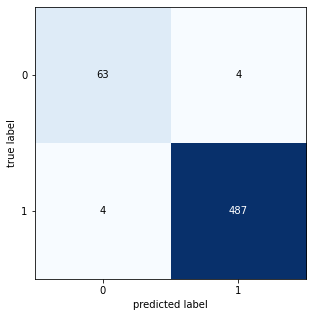

In [73]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = mnnb_clf.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
fig, ax = plot_confusion_matrix(cm,figsize=(5,5))
plt.show()

Area under curve:  0.9857129829467732


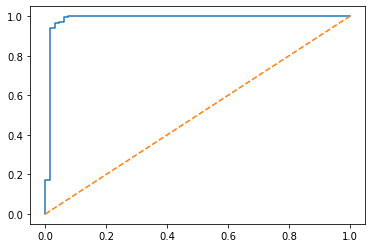

In [78]:
# ROC curve and ROC-auc-score
from sklearn.metrics import roc_curve, roc_auc_score
y_proba = mnnb_clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_proba)
print('Area under curve: ',roc_auc_score(y_test,y_proba))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')
plt.show()